In [1]:
import numpy as np
import os
import pandas as pd
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import torch
from torch import Tensor, tensor
from torch.nn.modules.loss import CrossEntropyLoss, BCELoss
from torchvision.transforms import *
from torchvision.transforms import functional
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import *
from PIL import Image
from matplotlib import cm
import pickle
import torchvision.transforms.functional as fn
%matplotlib inline

In [2]:
def checkpoint_save(data, fname):
    with open(fname, 'wb') as f:
        pickle.dump(data, f)

In [3]:
image_size = (100, 360)
BATCH_SIZE = 1

alphabet = [char for char in """абвгдеёжзийклмнопрстуфхцчшщъыьэюя"""]
def char_to_num(char: str) -> str:
    return str(alphabet.index(char))

def num_to_char(num: Union[str, int]) -> str:
    return alphabet[int(num)]

def num_to_tensor(num):
    return tensor([0 if i != num else 1 for i in range(len(alphabet))])

def show_image(img_tensor, borders: List[Tuple[int, int]], border_color: int = 0):
    img_tensor = img_tensor[:]
    for left, right in borders:
        for y in range(img_tensor.shape[0]):
            img_tensor[y, int(left)] = img_tensor[y, int(right)] = border_color
    plt.figure()
    plt.imshow(img_tensor.cpu().detach().numpy())

def show_images(samples: Sequence[Tuple[Tensor, List[Tuple[Tuple[int, int], str]]]], border_color: int = 2):
    for image, borders in samples:
        show_image(image, borders, border_color)

def show_samples(samples):
    for img, bs in samples:
        show_image(img, bs[0])

def get_comp(lst, comp: int):
    lst = [elem[comp] for elem in lst]
    return torch.cat(tuple(lst), dim=0)

def recalc_borders(dx: int, 
                   old_bords: List[Tuple[Tuple[int, int], int]]) -> \
        List[Tuple[Tuple[int, int], int]]:
    res = []
    for i in range(len(old_bords)):
        old_bords[i][0] = (tensor(old_bords[i][0]) + dx).to(device)
    
    return old_bords

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resize = lambda img, size: fn.resize(img.view(1, *img.shape), size).view(*size).to(device)

def get_data(checkpoint_step=20000):
    from google.colab import drive
    drive.mount('/content/drive')
    data = []

    dataset_filenames = ['my_dataset10000', ]#'my_dataset70000', ]#'my_dataset30000', 'my_dataset50000', 'my_dataset70000', 'my_dataset76626']
    for fname in dataset_filenames:
        with open('/content/drive/My Drive/Colab Notebooks/diplom/resourses/%s' % fname, 'rb') as f:
            data += pickle.load(f)

    drive.flush_and_unmount()

    for img, symbols in data:
        for i in range(len(symbols)):
            symbols[i] = [list(symbols[i][0]), tensor([int(char_to_num(symbols[i][1].lower()))], device=device)]#num_to_tensor(int(char_to_num(symbols[i][1].lower()))).to(device)]

    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

    data_transforms = Compose([
        Lambda(lambda x: (tensor(x[0]) / 255, x[1])),
        Lambda(lambda x: (functional.pad(x[0], 
                    ((image_size[1] - x[0].shape[1]) // 2, (image_size[0] - x[0].shape[0]) // 2),
                    fill=1), 
            recalc_borders(dx=(image_size[1] - x[0].shape[1]) // 2, old_bords=x[1]))),
        
        Lambda(lambda x: (resize(x[0], image_size), 
                          (get_comp(x[1], 0).view(-1, 2), get_comp(x[1], 1).view(-1)) 
                          )) # некоторые изображения имеют размер на 1 меньше нужного из-за округления
    ])

    data = [elem for elem in data if elem[0].shape[0] * elem[0].shape[1] > 50 and len(elem[1])]

    tdata = []
    for i in tqdm(range(len(data))):
        new_sample = data_transforms(data[i])
        if len(new_sample[1][0]):
            tdata.append(new_sample)

        if i % checkpoint_step == 0 and i != 0:
            checkpoint_save(tdata, fname='data after %s iters' % str(i))
            tdata = []
    
    if checkpoint_step < len(tdata):
        checkpoint_save(tdata, fname='data after end')

    print(len(tdata))
    return tdata

Mounted at /content/drive


  0%|          | 0/9715 [00:00<?, ?it/s]

9715
(tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), (tensor([[112, 166],
        [170, 206],
        [210, 249]]), tensor([25,  6, 12])))


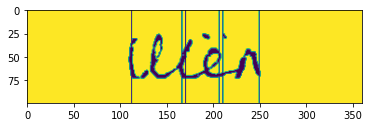

In [4]:
tdata = get_data(100000)
print(tdata[0])

show_samples([tdata[0]])

In [ ]:
show_samples(tdata[10011: 10019])

In [ ]:
def load_all_data(fnames):
    data = []
    for fname in fnames:
        with open(fname, 'rb') as f:
            data += pickle.load(f)

    return data

#tdata = load_all_data(['data after 10000 iters', 'data after 20000 iters', 'data after 30000 iters', 'data after 40000 iters',
#                              'data after 50000 iters', 'data after 60000 iters', 'data after 70000 iters', 'data after end'])

In [ ]:
#val_data = train_data = DataLoader(tdata, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
test_len = int(0.1 * len(tdata))
train_len = len(tdata) - test_len
train, val = data_utils.random_split(tdata, [train_len, test_len], generator=torch.Generator().manual_seed(42))
train_data = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_data = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
len(train_data), len(val_data)

(8744, 971)

In [ ]:
def save_data(obj, fname='data'):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)
    print('data saved')

def load_data(fname='train_val_data'):
    with open(fname, 'rb') as f:
        train, val = pickle.load(f)

    return train, val

In [ ]:
save_data(val_data, 'val_data')

In [ ]:
save_data(train_data, 'train_data')

In [6]:
def save_in_drive(obj, fname='train_val_data'):
    from google.colab import drive
    drive.mount('/content/drive')

    with open('/content/drive/My Drive/Colab Notebooks/diplom/resourses/%s' % fname, 'wb') as f:
        pickle.dump(obj, f)

    drive.flush_and_unmount()

def load_from_drive(fname='train_val_data'):
    from google.colab import drive
    drive.mount('/content/drive')

    with open('/content/drive/My Drive/Colab Notebooks/diplom/resourses/%s' % fname, 'rb') as f:
        res = pickle.load(f)

    drive.flush_and_unmount()
    return res

In [ ]:
save_in_drive((train_data, val_data), 'train_val_data')

In [ ]:
train_data, val_data = load_from_drive()

***Строим модель***

Модель похожа на архитектуру yolo, только для случая одномерной детекции, когда второе измерение не определяется

In [ ]:
# Определим, сколько в среднем занимает один символ
a = []
for X, y in tqdm(train_data):
    boxes, labels = y
    for box in boxes:
        a.append(box[0][1] - box[0][0])

tensor(a, dtype=torch.float).view(-1).mean()
# примерно 37 пикселов

  0%|          | 0/8744 [00:00<?, ?it/s]

tensor(49.4323)

In [7]:
width_of_bb = 47#37
NUM_OF_BB = 45
n_classes = 33
DX_CENTER = 360 // NUM_OF_BB

priors_cxs = tensor([DX_CENTER * (i + 0.5) for i in range(NUM_OF_BB)])
priors = tensor([[priors_cxs[i] - 0.5 * width_of_bb, priors_cxs[i] + 0.5 * width_of_bb] for i in range(NUM_OF_BB)]).to(device)
BB_OUTPUT = 35

HIDDEN_STATE_DIM = 512


class GatedConvolution(nn.Module):
    def __init__(self, img_shape, **conv_args):
        super(GatedConvolution, self).__init__()
        self.conv = nn.Conv2d(conv_args['out_channels'], conv_args['out_channels'], kernel_size=conv_args['kernel_size'], padding=conv_args['padding'])

    def forward(self, x):
        return torch.tanh(self.conv(x)) * x


def extended_conv_layer(img_shape, **conv_params):
    return nn.Sequential(
        *[
           nn.Conv2d(**conv_params, ),
           nn.PReLU(),
           nn.BatchNorm2d(conv_params['out_channels']),
           GatedConvolution(img_shape, **conv_params)
        ]
    )


from torch.nn.modules.dropout import Dropout2d
from torch.nn.modules.activation import Sigmoid
class MyDetector(nn.Module):
    def __init__(self):
        super(MyDetector, self).__init__()

        self.encoder = nn.Sequential(
            *[
                # 1x360x80
                extended_conv_layer(img_shape=(100, 360), in_channels=1, out_channels=8, kernel_size=3, padding=1),
                #extended_conv_layer(img_shape=(100, 360), in_channels=4, out_channels=8, kernel_size=3, padding=1),
                nn.MaxPool2d(kernel_size=2, stride=2), 

                # 16x180x40
                extended_conv_layer(img_shape=(50, 180), in_channels=8, out_channels=16, kernel_size=3, padding=1),
                #extended_conv_layer(img_shape=(50, 180), in_channels=16, out_channels=16, kernel_size=3, padding=1),
                nn.Dropout2d(p=0.2),
                nn.AvgPool2d(kernel_size=2, stride=2),

                # 32x90x20
                extended_conv_layer(img_shape=(25, 90), in_channels=16, out_channels=BB_OUTPUT, kernel_size=3, padding=1),
                #extended_conv_layer(img_shape=(25, 90), in_channels=BB_OUTPUT, out_channels=BB_OUTPUT, kernel_size=3, padding=1),
                nn.Dropout2d(p=0.2),
                nn.AvgPool2d(kernel_size=2, stride=2),
              
                # 36x45x10
                #extended_conv_layer(img_shape=(10, 45), in_channels=BB_OUTPUT, out_channels=BB_OUTPUT, kernel_size=3, padding=1),
                nn.Conv2d(in_channels=BB_OUTPUT, out_channels=BB_OUTPUT, kernel_size=(12, 1)),
                nn.Conv2d(in_channels=BB_OUTPUT, out_channels=BB_OUTPUT, kernel_size=(1, 1)),
                nn.Dropout2d(p=0.2),
                # 36x45x1
                nn.Flatten(),
                #nn.LazyLinear(out_features=HIDDEN_STATE_DIM),
                nn.LazyLinear(out_features=NUM_OF_BB*BB_OUTPUT),
            ]
        )

        self.init_conv()

    def init_conv(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d) or isinstance(c, nn.Conv3d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def cx_to_priors(self, cs: Tensor):
        '''
        :cs: тензор с парами (cx, w) -- (batch_size, NUM_OF_BB, 2)
        :возвращает тензор с парами (lx, rx) -- (batch_size, NUM_OF_BB, 2)
        '''
        left = cs[:, :, 0] - cs[:, :, 1] / 2
        right = cs[:, :, 0] + cs[:, :, 1] / 2
        return torch.cat((left.view(BATCH_SIZE, NUM_OF_BB, 1), right.view(BATCH_SIZE, NUM_OF_BB, 1)), dim=2)

    def forward(self, x: Tensor):
        enc= self.encoder(x).view(-1, NUM_OF_BB, BB_OUTPUT)  # 1x45x35

        for i in range(NUM_OF_BB):
            enc[:, i, 0] = torch.tanh(enc[:, i, 0]) * width_of_bb + priors_cxs[i]  # -1...1 * width_of_bb -- сдвиг относительно priors_cxs[i]
            enc[:, i, 1] = torch.relu(enc[:, i, 1]) * width_of_bb #+ priors_cxs[i]  # ширина найденной зоны
            enc[:, i, 2: ] = torch.sigmoid(enc[:, i, 2: ])

        locs = self.cx_to_priors(enc[:, :, 0:2])
        class_scores = enc[:, :, 2:]

        return locs, class_scores

In [8]:
EPS = 1e-4
IoU_THRESHOLD = 0.5
alpha = 1

ce_loss = nn.functional.cross_entropy

def IoU(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 2)
    :param set_2: set 2, a tensor of dimensions (n2, 2)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """
    set_1 = set_1.view(-1, 2)
    set_2 = set_2.view(-1, 2)
    # Find intersections
    lower_bounds = torch.max(set_1[:, 0].unsqueeze(1), set_2[:, 0].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 1].unsqueeze(1), set_2[:, 1].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, )
    intersection = intersection_dims#[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)
    
    # Find unions
    union = (set_1[:, 1] - set_1[:,  0]).unsqueeze(1) + (set_2[:, 1] - set_2[:, 0]).unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

smooth_l1 = nn.L1Loss()
neg_pos_ratio = 10
cross_entropy = nn.CrossEntropyLoss(reduce=False)

def loss_function(predicted_locs, predicted_scores, true_boxes, true_labels, print_info=False) -> float:
    """
        Forward propagation.
        :param predicted_locs: predicted locations/boxes w.r.t the NUM_OF_BB prior boxes, a tensor of dimensions (N, NUM_OF_BB, 2)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, NUM_OF_BB, n_classes)
        :param true_boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param true_labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
    """
    true_locs = torch.zeros((BATCH_SIZE, NUM_OF_BB, 2), dtype=torch.float).to(device)  # (1, 45, 2)
    true_classes = torch.zeros((BATCH_SIZE, NUM_OF_BB), dtype=torch.long).to(device)  # (1, 45)

    # For each image
    for i in range(BATCH_SIZE):
        n_objects = true_boxes[i].size(0)

        overlap = IoU(true_boxes, priors)  # (n_objects, NUM_OF_BB)

        # For each prior, find the object that has the maximum overlap
        overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (NUM_OF_BB)

        # We don't want a situation where an object is not represented in our positive (non-background) priors -
        # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
        # 2. All priors with the object may be assigned as background based on the threshold (0.5).

        # To remedy this -
        # First, find the prior that has the maximum overlap for each object.
        _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

        # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
        object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

        # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
        overlap_for_each_prior[prior_for_each_object] = 1.

        # Labels for each prior
        label_for_each_prior = true_labels[i][object_for_each_prior]  # (NUM_OF_BB)
        # Set priors whose overlaps with objects are less than the threshold to be background (no object)
        label_for_each_prior[overlap_for_each_prior < IoU_THRESHOLD] = 0  # (NUM_OF_BB)
        #print(label_for_each_prior.sum(dim=1))

        # Store
        true_classes[i] = label_for_each_prior

        # Encode center-size object coordinates into the form we regressed predicted boxes to
        true_locs[i] = true_boxes[i][object_for_each_prior]  # cxcy_to_gcxgcy(xy_to_cxcy(true_boxes[i][object_for_each_prior]), priors_cxs)  # (8732, 4)

    # Identify priors that are positive (object/non-background)
    positive_priors = true_classes != 0 #label_for_each_prior[label_for_each_prior.any(dim=1)]  # (N, NUM_OF_BB)

    # LOCALIZATION LOSS

    # Localization loss is computed only over positive (non-background) priors
    loc_loss = smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

    # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & NUM_OF_BB)
    # So, if predicted_locs has the shape (N, NUM_OF_BB, 2), predicted_locs[positive_priors] will have (total positives, 2)

    # CONFIDENCE LOSS

    # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
    # That is, FOR EACH IMAGE,
    # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
    # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

    # Number of positive and hard-negative priors per image
    n_positives = positive_priors.sum(dim=1)  # (N)
    n_hard_negatives = neg_pos_ratio * n_positives  # (N)

    # First, find the loss for all priors
    conf_loss_all = cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * NUM_OF_BB)
    conf_loss_all = conf_loss_all.view(BATCH_SIZE, NUM_OF_BB)  # (N, NUM_OF_BB)

    # We already know which priors are positive
    conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

    # Next, find which priors are hard-negative
    # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
    conf_loss_neg = conf_loss_all.clone()  # (N, NUM_OF_BB)
    conf_loss_neg[positive_priors] = 0.  # (N, NUM_OF_BB), positive priors are ignored (never in top n_hard_negatives)
    conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, NUM_OF_BB), sorted by decreasing hardness
    hardness_ranks = torch.LongTensor(range(NUM_OF_BB)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, NUM_OF_BB)
    hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, NUM_OF_BB)
    conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

    # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
    conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

    # TOTAL LOSS
    if print_info:
        print('conf: %f\tloc: %f' % (conf_loss, loc_loss))
    return conf_loss + alpha * loc_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [10]:
def train(model, train_data, val_data, n_epoques, loss_fn, optimizer, train_losses=None, val_losses=None):
    if train_losses is None:
        train_losses = []
        val_losses = []

    for epoque in tqdm(range(n_epoques)):
        model.train()
        epoque_train_losses = []


        for X, y in tqdm(train_data):
            optimizer.zero_grad()
            X = X.to(device)
            y_pred = model(X.view(-1, 1, *image_size))
            predicted_locs, predicted_scores, true_boxes, true_labels = y_pred[0], y_pred[1], y[0], y[1]

            loss = loss_fn(predicted_locs, predicted_scores, true_boxes, true_labels)
            if torch.isnan(loss):
                continue
                
            loss.backward()
            optimizer.step()

            epoque_train_losses.append(loss.item())

        train_losses.append(np.mean(epoque_train_losses))

        model.eval()
        epoque_val_losses = []
        with torch.no_grad():
          for X, y in tqdm(val_data):
            X = X.to(device)
            y_pred = model(X.view(-1, 1, *image_size))
            predicted_locs, predicted_scores, true_boxes, true_labels = y_pred[0], y_pred[1], y[0], y[1]
            
            loss = loss_fn(predicted_locs, predicted_scores, true_boxes, true_labels)
            if torch.isnan(loss):
                continue
            
            epoque_val_losses.append(loss.item())

        val_losses.append(np.mean(epoque_val_losses))

        print("Epoque %d / %d" % (int(epoque) + 1, n_epoques))
        print("mean train loss: %f" % train_losses[-1])
        print("mean val loss: %f" % val_losses[-1])
        plt.close()
        plt.figure()
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.legend(['train', 'val'])

        #test_model(model, X[0:2])
        plt.show()
        
    return train_losses, val_losses

In [11]:
train_losses, val_losses, model = load_from_drive('25_iters_1')
model = model.to(device)

Mounted at /content/drive


In [12]:
#model = MyDetector().to(device)

optimizer = optim.RMSprop(model.parameters(), lr=0.00015)#Adam(model.parameters())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 1 / 5
mean train loss: 19.440040
mean val loss: 17.971864


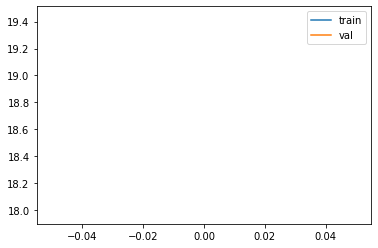

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 2 / 5
mean train loss: 17.846567
mean val loss: 17.436428


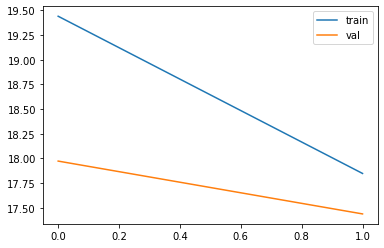

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 3 / 5
mean train loss: 17.332097
mean val loss: 16.970133


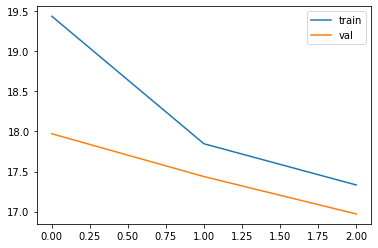

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 4 / 5
mean train loss: 17.094776
mean val loss: 16.877550


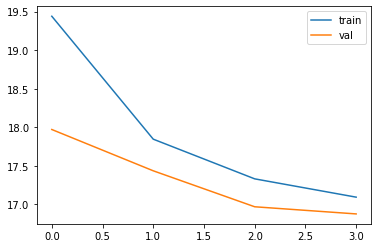

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 5 / 5
mean train loss: 16.952858
mean val loss: 16.820613


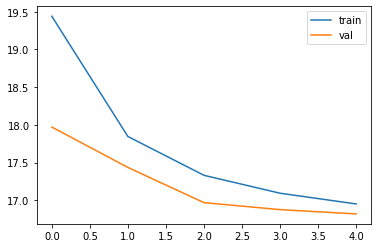

Mounted at /content/drive


In [ ]:
train_losses, val_losses = train(model, train_data, val_data, 5, loss_function, optimizer)
save_in_drive((train_losses, val_losses, model.to('cpu')), '5_iters_1')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 1 / 10
mean train loss: 15.528492
mean val loss: 16.108031


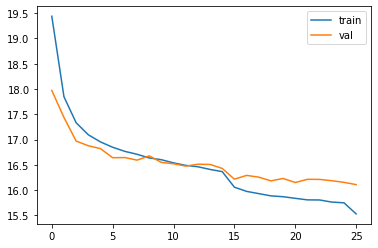

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 2 / 10
mean train loss: 15.471966
mean val loss: 16.124614


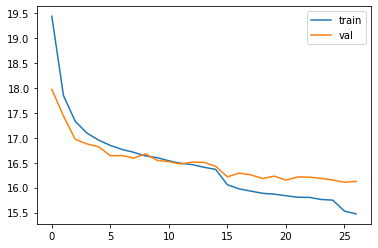

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 3 / 10
mean train loss: 15.454195
mean val loss: 16.074746


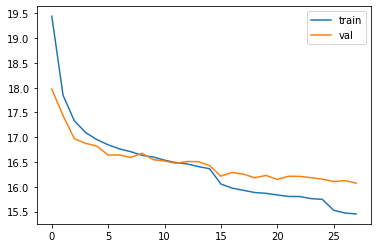

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 4 / 10
mean train loss: 15.423324
mean val loss: 16.064868


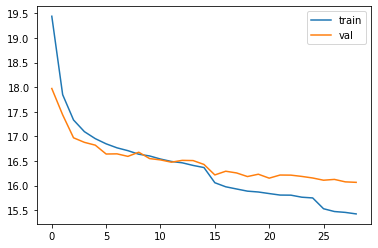

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 5 / 10
mean train loss: 15.416811
mean val loss: 16.043073


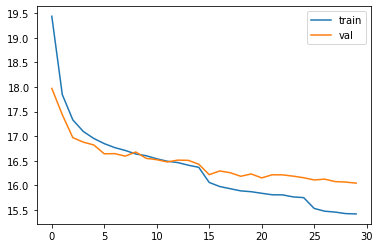

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 6 / 10
mean train loss: 15.403221
mean val loss: 16.096425


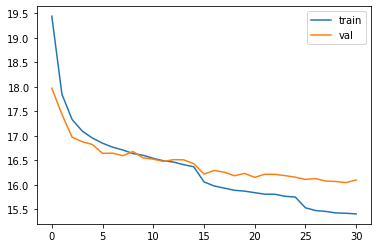

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 7 / 10
mean train loss: 15.393174
mean val loss: 16.076232


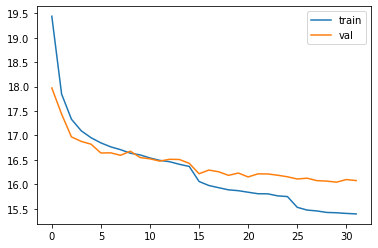

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 8 / 10
mean train loss: 15.391425
mean val loss: 16.115217


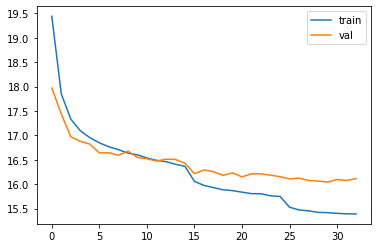

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 9 / 10
mean train loss: 15.365697
mean val loss: 16.070645


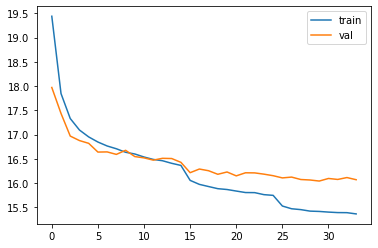

  0%|          | 0/8744 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 10 / 10
mean train loss: 15.355165
mean val loss: 16.027078


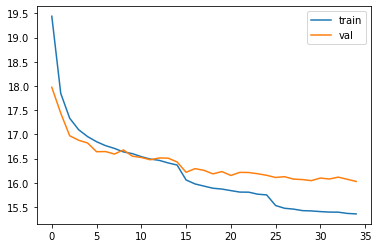

Mounted at /content/drive


In [13]:
train_losses, val_losses = train(model.to(device), train_data, val_data, 10, loss_function, optimizer, train_losses, val_losses)
save_in_drive((train_losses, val_losses, model.to('cpu')), '35_iters_1')

In [ ]:
save_in_drive((train_losses, val_losses, model.to('cpu')), '40_iters_lite')

Mounted at /content/drive


In [14]:
def show_result(X, pred_locs, pred_classes):
    show_image(X.view(*image_size), pred_locs.to(torch.int32).view(-1, 2).max(tensor([0])).min(tensor([359])))

conf: 8.165710	loc: 8.720422
loss: 16.886131
torch.return_types.max(
values=tensor([0.0026, 0.0022, 0.0036, 0.0026, 0.0025, 0.0041, 0.0046, 0.0071, 0.0069,
        0.0219, 0.0363, 0.2546, 0.5211, 0.3729, 0.4852, 0.7923, 0.7926, 0.8318,
        0.8291, 0.7226, 0.9839, 0.9956, 0.9986, 0.9334, 0.3477, 0.7935, 0.9545,
        0.9805, 0.9251, 0.4744, 0.4546, 0.2907, 0.2794, 0.0935, 0.0439, 0.0191,
        0.0103, 0.0074, 0.0051, 0.0052, 0.0025, 0.0026, 0.0032, 0.0023, 0.0023]),
indices=tensor([14, 18, 18, 18, 18, 15, 15,  1,  1, 17, 18,  2, 18, 18, 14, 14, 19, 19,
        19, 16, 16, 16, 16, 16, 16, 19, 19, 19, 19, 19, 19, 18, 18,  7,  7,  7,
         7,  9,  9, 14, 14, 13, 13, 13,  8]))
torch.Size([45, 33])


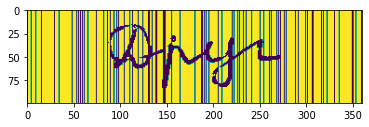

In [18]:
thres = 0.9
model.eval()
with torch.no_grad():
    for X, y in val_data:
        X = X.to(device)
        y_pred = model(X.view(-1, 1, *image_size))
        predicted_locs, predicted_scores, true_boxes, true_labels = y_pred[0], y_pred[1], y[0], y[1]
            
        loss = loss_function(predicted_locs, predicted_scores, true_boxes, true_labels, True)
        print('loss: %f' % loss)

        predicted_locs = predicted_locs.view(45, 2)
        predicted_scores = predicted_scores.view(45, 33)
        locs = predicted_locs[(predicted_scores[:, 1: ] > thres).any()]
        #print(torch.max(predicted_scores[(predicted_scores > thres).any()], dim=1))
        print(torch.max(predicted_scores[:, 1:], dim=1))
        show_result(X, locs, predicted_scores)
        print((predicted_scores.shape))
        break
        

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8746 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 1 / 5
mean train loss: 18.666939
mean val loss: 20.203562


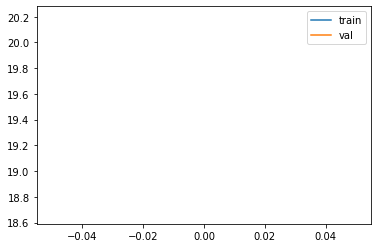

  0%|          | 0/8746 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 2 / 5
mean train loss: 18.798480
mean val loss: 20.029778


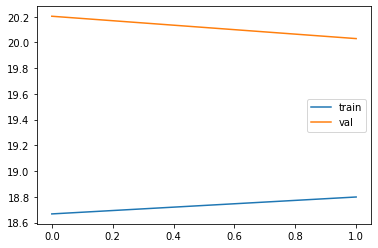

  0%|          | 0/8746 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 3 / 5
mean train loss: 18.679395
mean val loss: 19.201926


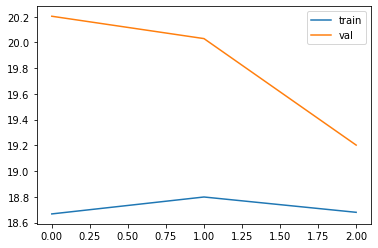

  0%|          | 0/8746 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 4 / 5
mean train loss: 18.562274
mean val loss: 19.739077


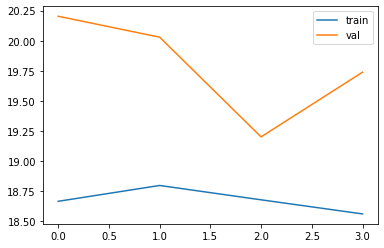

  0%|          | 0/8746 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Epoque 5 / 5
mean train loss: 19.139292
mean val loss: 20.203276


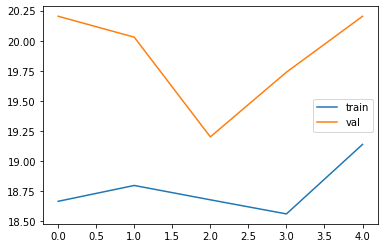

In [ ]:
train(model, train_data, val_data, 5, loss_function, optimizer)

In [ ]:
for X, y in val_data:
    X = X.to(device)
    y_pred = model(X.view(-1, 1, *image_size))
    predicted_locs, predicted_scores, true_boxes, true_labels = y_pred[0].view(-1, 2), y_pred[1].view(-1, 33), y[0], y[1]
    print(predicted_locs, predicted_scores)
    break

tensor([[-30.9734,  25.9272],
        [-13.3229,  40.8489],
        [  0.4547,  39.1116],
        [ 29.4396, 102.0626],
        [ 17.2543,  69.2779],
        [ 22.6744,  64.1899],
        [ 32.7792,  75.6324],
        [ 45.4991,  88.3761],
        [ 48.8094,  92.4556],
        [ 69.0134, 108.0034],
        [ 61.4352, 107.1036],
        [ 73.5201, 111.1986],
        [ 82.9825, 126.7225],
        [ 87.3758, 129.6943],
        [ 93.6834, 127.6549],
        [ 97.9009, 132.3622],
        [ 99.9921, 140.2501],
        [115.0279, 156.4602],
        [133.5051, 166.9481],
        [136.4350, 171.9864],
        [151.4946, 190.4689],
        [161.8670, 194.7704],
        [165.8593, 205.3061],
        [172.6299, 211.4119],
        [172.5221, 207.6776],
        [178.3632, 215.6279],
        [198.8263, 235.7431],
        [213.1433, 248.7037],
        [221.1646, 253.4498],
        [220.5590, 259.0071],
        [223.7132, 264.0787],
        [230.0783, 271.1088],
        [240.2081, 282.4903],
        [2

**Теперь подготовим выборку для обучения алгоритма постобработки** 

In [ ]:
import pickle
from google.colab import files


In [ ]:
def xborders(img):
    left, right = 0, 511
    for x in range(512):
        if img[:, x].all():
            left += 1
        else:
            break
    for x in range(511, 0, -1):
        if img[:, x].all():
            right -= 1
        else:
            break
    return left, right

def vector_to_char(vector):
    if np.sum(vector) > 0:
        v = list(vector)
        return alphabet[v.index(np.max(v))]
    else:
        return ''

def tensor_to_word(tensor):
    res = ''
    for v in tensor:
        res += vector_to_char(v)
    return res

mydata = []
Y_THRESH = 0.59

for X, y in tqdm(val):
    ty = model(tensor(X).view(1, 1, 128, 512).to(device)).to('cpu').view(16, 36).detach().numpy()
    left, right = xborders(X)
    ty[:, : 2] -= left
    mydata.append(([(ty[i, 0], ty[i, 1], vector_to_char(ty[i, 3: ]), ty[i, 2]) for i in range(len(ty)) if ty[i][2] >= Y_THRESH],
                 right - left, tensor_to_word(y.numpy())))

file = open('mydata', 'wb')
pickle.dump(mydata, file)

  0%|          | 0/989 [00:00<?, ?it/s]

In [ ]:
ty[0, 4] 

0.61745

In [ ]:
!pip install asrtoolkit

In [ ]:
from __future__ import annotations
from typing import *
import random
import numpy as np


lambda_mu = 2


class Decision:
    DIAP: Tuple[float, float] = (-1, 1)

    variables: List[float]
    sigmas: List[float]
    estimation: Optional[float]

    def __init__(self, vars: List[float], sigmas: List[float],
                 estimator: Union[None, Callable[List[float], float]] = None):
        self.variables = vars
        self.sigmas = sigmas
        if estimator is not None:
            self.estimation = estimator(self.variables)
        else:
            self.estimation = None

    def update_estimation(self, estimator: Callable[List[float], float]) -> None:
        self.estimation = estimator(self.variables)

    @staticmethod
    def random_recombinate(a: Decision, b: Decision, pc: float = 0.5) -> Optional[List[Decision]]:
        r = random.random()
        if r <= pc:
            return Decision._recombinate(a, b)
        else:
            return None

    def __getitem__(self, item: int) -> float:
        return self.variables[item]

    @staticmethod
    def _recombinate(a: Decision, b: Decision) -> List[Decision]:
        res = []
        for _ in range(2 * lambda_mu):
            hv, hs = [], []
            for i in range(len(a.variables)):
                v, sigma = random.choice([(a.variables[i], a.sigmas[i]), (b.variables[i], a.sigmas[i])])
                hv.append(v), hs.append(sigma)
            res.append(Decision(hv, hs))
        return res

    def random_mutate(self, pm: float = 0.001) -> None:
        r = random.random()
        if r <= pm:
            self._mutate()

    def _mutate(self) -> None:
        self.variables += np.random.normal(0, self.sigmas, size=(len(self.variables, )))

    def __lt__(self, other: Decision) -> bool:
        return self.estimation < other.estimation

import random
import numpy as np


class Selector:
    pm: float
    pc: float
    func: Callable[List[float], float]
    population: List[Decision]

    def __init__(self, func: Callable[List[float], float], dim_of_vector: int,
                 size_of_population: int = 1000, pc: float = 0.5, pm: float = 0.01):
        # size_of_population -- четное число
        self.pm, self.pc = pm, pc
        self.func = func

        self.init_population(size_of_population, dim_of_vector)

    def init_population(self, size_of_population: int, dim_of_vector: int) -> None:
        SIGMA_DIAP = (0.09, 0.25)

        def make_random_sample() -> Tuple[List[float], List[float]]:
            return [Decision.DIAP[0] + random.random() * (Decision.DIAP[1] - Decision.DIAP[0])
                    for _ in range(dim_of_vector)], \
                   [SIGMA_DIAP[0] + random.random() * (SIGMA_DIAP[1] - SIGMA_DIAP[0])
                    for _ in range(dim_of_vector)]


        self.population = sorted(
            [Decision(*make_random_sample(), self.func)
             for _ in range(size_of_population)])

    @staticmethod
    def estimate(func: Callable[List[float], float], x: List[float]) -> float:
        return func(x)

    @staticmethod
    def find_pairs(l: int) -> List[Tuple[int, int]]:
        items = [i for i in range(l)]
        res = []
        while len(items):
            r1, r2 = random.randint(0, len(items) - 1), random.randint(0, len(items) - 2)
            a1 = items.pop(r1)
            a2 = items.pop(r2)
            res.append((a1, a2))
        return res

    def make_selection_round(self) -> None:
        pairs = Selector.find_pairs(len(self.population))
        new_pop = []

        for ia, ib in pairs:
            a, b = self.population[ia], self.population[ib]
            n = Decision.random_recombinate(a, b, self.pc)
            if not (n is None):
                for new in n:
                    new.random_mutate(1)
                    new_pop.append(new)

        t = self.population + new_pop
        for c in t:
            c.update_estimation(lambda x: Selector.estimate(self.func, x))

        t.sort()
        self.population = t[: len(self.population)]

    def make_selection(self, n_iters: int = 1000, n_to_stop: int = 20) -> Tuple[Decision, int]:
        best = self.population[0]
        cnt_best = 0
        i = 0
        for i in range(n_iters):
            self.make_selection_round()
            t = self.population[0]

            if t < best:
                best = t
                cnt_best = 0
            else:
                cnt_best += 1

            if cnt_best > n_to_stop:
                break

            print(i, best.estimation, best.variables)

        return best, i

    def get_points(self) -> List[List[float]]:
        return [p.variables.copy() for p in self.population]


MAX_LEFT_INDENT = 'max_left_indent'  # максимальный отступ левой границы первого символа от левой границы изображения
MAX_RIGHT_INDENT = 'max_right_indent'  # максимальный отступ правой границы последнего символа от правой границы
                                        # изображения
LIMIT_MOVING_LEFT = 'limit_moving_left'  # максимальное смещение влево левой границы следующего символа относительно
                                         # правой границы предыдущего
LIMIT_MOVING_RIGHT = 'limit_moving_right'  # максимальное смещение вправо левой границы следующего символа относительно
                                           # правой границы предыдущего

MLI_k, MRI_k, LML_k, LMR_k = 100, 100, 100, 100

import pickle
from asrtoolkit import cer
import numpy as np
file = open('ga_test', 'rb')
DATA = pickle.load(file)[: 100]
NO_ANSWER_PENALTY = 10


def estimate(vector: List[float], data: List[Tuple[List[Tuple[int, int, str, float]], int, str]] = DATA):
    score = 0
    for sample in data:
        symbols, imgwidth, result = sample
        params = Joiner.read_from_vector(vector)
        words = Joiner.join_components(symbols, params, imgwidth, 5)
        cers = [cer(word, result) for word, k in words]

        if len(words):
            score += np.max(cers)
        else:
            score += cer('', result)
    return score


class Joiner:

    @staticmethod
    def join_components(results: List[Tuple[int, int, str, float]], params: Dict, imgwidth: int,
                        max_num_of_variants: int) -> List[Tuple[str, float]]:

        def get_first_symbols() -> List[int]:
            return [i for i in range(len(results)) if results[i][0] <= params[MAX_LEFT_INDENT]]

        def get_next_symbol(done: List[int]) -> List:
            actual_right_border = results[done[-1]][1]
            return [i for i in range(len(results)) if i not in done and
                    params[LIMIT_MOVING_LEFT] <= results[i][0] - actual_right_border <= params[LIMIT_MOVING_RIGHT]]

        def may_be_end(done: List[int]) -> bool:
            return imgwidth - results[done[-1]][1] <= params[MAX_RIGHT_INDENT]

        def step_to(done) -> List[int]:
            # возвращает список возможных окончаний пройденного маршрута done
            mbroutes = [done + [var] for var in get_next_symbol(done)]
            res = []
            for route in mbroutes:
                res += step_to(route)
            if may_be_end(done) or len(mbroutes) == 0:
                res += [done]

            return res

        first_steps = get_first_symbols()  # представление дерева вариантов распознанных слов
        res = []

        for step in first_steps:
            res += step_to([step])

        words = []
        for route in res:
            word = ''
            confidence = 0
            for i in route:
                word += results[i][2]
                confidence += results[i][3]

            words.append((word, confidence / len(word)))

        words.sort(reverse=True, key=lambda x: x[1])
        if len(words) < max_num_of_variants:
            return words
        else:
            return words[: max_num_of_variants]

    @staticmethod
    def read_from_vector(vector: List[float]) -> Dict:
        return {
            MAX_LEFT_INDENT: vector[0] * MLI_k,
            MAX_RIGHT_INDENT: vector[1] * MRI_k,
            LIMIT_MOVING_LEFT: vector[2] * LML_k,
            LIMIT_MOVING_RIGHT: vector[3] * LMR_k
        }

In [ ]:
import time
start = time.time()
res = Selector(estimate, 4, pc = 0.8, pm=0.05, size_of_population=30).make_selection(100)
print(res[0].estimation)
print(res[0])
print(res[1])
print('time: %f' % (time.time() - start))

0 14980.0 [ 0.51839886 -0.56724492 -1.13077306  1.06412559]
1 14980.0 [ 0.51839886 -0.56724492 -1.13077306  1.06412559]
2 14530.238095238097 [ 0.66645919  0.24123719 -0.99533884  1.23752719]
3 13576.071428571428 [ 0.88773216 -0.86508129 -0.73180052  1.62960591]
4 12940.476190476193 [ 0.65232084  0.24852635 -1.3197841   1.48182935]
5 12862.380952380956 [ 0.71769044  0.40875207 -1.76645253  1.48550669]
6 12681.309523809527 [ 0.67493108 -1.54764341 -0.7646183   2.00680861]
7 12089.365079365083 [ 0.88215566 -1.58170642 -1.383182    1.89204895]
8 11898.09523809524 [ 0.77938908 -1.85820808 -1.21194813  2.12026789]
9 11880.476190476193 [ 0.61149735 -1.52645683 -1.4754677   2.14861267]
10 11737.460317460316 [ 0.52880813 -1.03727721 -1.2761935   2.36387839]


KeyboardInterrupt: ignored